In [772]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow import keras

import pickle

# For print and drawing results
import result_functions

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 7

# Preprocessing

### Clear data

In [517]:
# Load and save data
df = pd.read_csv("data/Aboutlabeled.csv")
df = df.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Offsets', 'ID'],  axis=1)

# index of incorrect labels
incorrect_labels_index = df[(df['Label'] != 'About') & (df['Label'] != 'None')].index
# delete empty and incorrect rows
df.drop(index=incorrect_labels_index, axis=0, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16652 entries, 0 to 16720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    16652 non-null  object
 1   Label   16652 non-null  object
dtypes: object(2)
memory usage: 390.3+ KB


In [4]:
df.head()

,Text,Label
0,Funding Circle was created with a big idea:,None
1,To revolutionize the outdated banking system a...,About
2,"Thousands of loans later, we've helped busines...",About
3,We've taken this progress global.,About
4,Funding Circle is the world's leading marketpl...,About


### Preprocessing

In [518]:
# Counts the number of words
df['num_of_words'] = df['Text'].apply(lambda text: len(text.split()))
df.head()

,Text,Label,num_of_words
0,Funding Circle was created with a big idea:,None,8
1,To revolutionize the outdated banking system a...,About,13
2,"Thousands of loans later, we've helped busines...",About,14
3,We've taken this progress global.,About,5
4,Funding Circle is the world's leading marketpl...,About,30


In [519]:
df.groupby(['Label'])['num_of_words'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
About,1867.0,23.128013,9.419610,4.0,16.0,22.0,28.0,107.0
None,14785.0,13.237606,10.859506,1.0,4.0,11.0,20.0,118.0


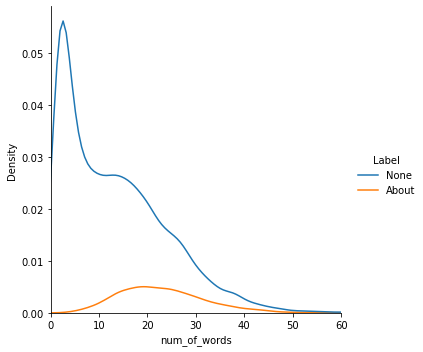

In [520]:
# Distribution for the 'About' label
g = sns.displot(data = df, 
                 x= 'num_of_words',
                 hue='Label',
                 kind='kde')
g.set(xlim=(0, 60))
# sns.displot(data = df, x = df['num_of_words'][df['Label'] == 'None'], label='sdf', ax = ax)

#### *We can see a different distribution of labels*

#### *Add the presence of "we" / "our" in the sentence as a binary feature*

In [521]:
# Calculate the number of words "we" / "our" in the text

text = df['Text'].str.lower()

has_we = text.str.count("we ").astype(int)
has_we += text.str.count("we'").astype(int)
has_we += text.str.count(" we").astype(int)
print(f"has_we: {len(has_we[has_we != 0])}")

has_our = text.str.count("our ").astype(int)
has_our += text.str.count("our'").astype(int)
has_our += text.str.count(" our").astype(int)
print(f"has_our: {len(has_our[has_our != 0])}")


# has_we = text.str.contains('we', case=False)
# has_our = text.str.contains('our', case=False)

df['has_we'] = has_we.astype(int)
df['has_our'] = has_our.astype(int)

has_we: 2946
has_our: 3011


#### *Yes, some cases will count twice, but the mean difference in this way for the label is better*

In [523]:
df.groupby(['Label'])['has_we', 'has_our'].describe()

has_we                                                has_our  \
         count      mean       std  min  25%  50%  75%   max    count   
Label                                                                   
About   1867.0  0.441350  0.781048  0.0  0.0  0.0  1.0   6.0   1867.0   
None   14785.0  0.268583  0.719832  0.0  0.0  0.0  0.0  10.0  14785.0   

                                                     
           mean       std  min  25%  50%  75%   max  
Label                                                
About  0.521157  1.074381  0.0  0.0  0.0  1.0  10.0  
None   0.335610  0.880998  0.0  0.0  0.0  0.0  14.0

In [524]:
df.head()

,Text,Label,num_of_words,has_we,has_our
0,Funding Circle was created with a big idea:,None,8,0,0
1,To revolutionize the outdated banking system a...,About,13,0,0
2,"Thousands of loans later, we've helped busines...",About,14,2,0
3,We've taken this progress global.,About,5,1,0
4,Funding Circle is the world's leading marketpl...,About,30,0,0


In [525]:
# Prepare X
X = df.drop(['Label'], axis = 1)
# Prepare labels
y = df['Label'].map({'None': 0, 'About': 1})

In [526]:
df

,Text,Label,num_of_words,has_we,has_our
0,Funding Circle was created with a big idea:,None,8,0,0
1,To revolutionize the outdated banking system a...,About,13,0,0
2,"Thousands of loans later, we've helped busines...",About,14,2,0
3,We've taken this progress global.,About,5,1,0
4,Funding Circle is the world's leading marketpl...,About,30,0,0
...,...,...,...,...,...
16716,Dr. Holtz has held research management positio...,None,18,0,0
16717,He received his Ph.D. at Pennsylvania State Un...,None,19,0,0
16718,Dr. Holtz has been awarded 22 US patents and h...,None,15,0,0
16719,Dr. Holtz was awarded the Pennsylvania State U...,None,13,0,0


In [828]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)
# Split X_val, y_val into validation and test data
X_val, X_test, y_val, y_test = train_test_split(X_val, 
                                                y_val, 
                                                train_size = 0.7, 
                                                shuffle=True,
                                                random_state=RANDOM_STATE)

y_train.value_counts()

0    10367
1     1289
Name: Label, dtype: int64

In [837]:
# Save test data
with open('data/text_test.pkl', 'wb') as file:
    pickle.dump(X_test['Text'].values.tolist(), file)
with open('data/labels_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [672]:
# Create OverSampler and resample X_train, y_train train
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversampler.fit_resample(pd.DataFrame(X_train), y = y_train)
# X_train = [i[0] for i in X_train.values.tolist()]
y_train.value_counts()

1    10367
0    10367
Name: Label, dtype: int64

In [673]:
X_train_text = X_train['Text']
X_train.drop('Text', inplace=True, axis=1)
X_val_text = X_val['Text']
X_val.drop('Text', inplace=True, axis=1)
X_test_text = X_test['Text']
X_test.drop('Text', inplace=True, axis=1)

# LinearRegression

In [74]:
%%time
# Create and fit LinearRegression model
lr_model = LinearRegression()
lr_model.fit(X_train.values, y_train.values)

CPU times: user 2.83 ms, sys: 1.88 ms, total: 4.71 ms
Wall time: 3.09 ms


LinearRegression()

Accuracy score: 0.696
Precision score: 0.228
Recall score: 0.681
F-score: 0.342

Max F1-Score: 0.345 (threshold: 0.475)



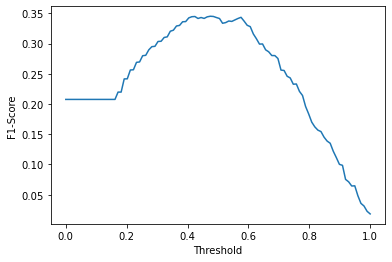

In [442]:
# Linear Regression estimate
result_functions.print_scores(y_val, lr_model.predict(X_val), plot_fscore_threshold=True)

In [453]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [456]:
y_pred_rfc = RFC.predict(X_val)

Accuracy score: 0.627
Precision score: 0.207
Recall score: 0.783
F-score: 0.327

Max F1-Score: 0.327 (threshold: 0.0)



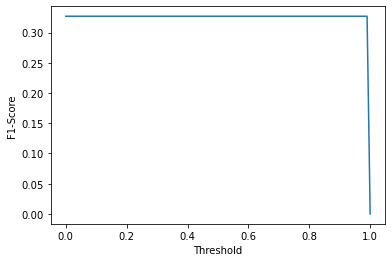

In [457]:
# Linear Regression estimate
result_functions.print_scores(y_val, y_pred_rfc, plot_fscore_threshold=True)

# Embedding layer

In [799]:
class Preprocessing():
    
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        pass
    
    def transform(self, X):
        if type(X) == str:
            X = [X]
        
        X = tokenizer.texts_to_sequences(X)
        X = keras.preprocessing.sequence.pad_sequences(X, 
                                                       padding='post',
                                                       maxlen=50)
        
        return X

In [800]:
with open('models/preprocessing.pkl', 'wb') as file:
    pickle.dump(Preprocessing, file)

In [674]:
maxlen = 50

# Create a tokenizer and encode words for sequences of numbers
keras_tokenizer = keras.preprocessing.text.Tokenizer()
keras_tokenizer.fit_on_texts(X_train_text.values)

# Encode texts to sequences of numbers
X_train_text_v = keras_tokenizer.texts_to_sequences(X_train_text)
X_train_text_v = keras.preprocessing.sequence.pad_sequences(X_train_text_v, 
                                                         padding='post', 
                                                         maxlen=maxlen)
X_val_text_v = keras_tokenizer.texts_to_sequences(X_val_text)
X_val_text_v = keras.preprocessing.sequence.pad_sequences(X_val_text_v, 
                                                       padding='post',
                                                       maxlen=maxlen)


vocab_size = len(keras_tokenizer.word_index) + 1 # Vocabulary size and reserved index '0'

print(f"Vocabulary size: {vocab_size}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

Vocabulary size: 15805
X_train shape: (20734, 3)
X_val shape: (3497, 3)


In [788]:
# Save keras_tokenizer
with open('models/keras_tokenizer.pkl', 'wb') as file:
    pickle.dump(keras_tokenizer, file)

In [700]:
# Build a NN with a embedding layer
emb_model = keras.models.Sequential()
emb_model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                     output_dim=85,
                                     input_length=maxlen))
emb_model.add(keras.layers.Dropout(0.6))
emb_model.add(keras.layers.Flatten())
emb_model.add(keras.layers.Dense(1, activation='sigmoid'))
emb_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'Precision', 'Recall'])
emb_model.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, 50, 85)            1343425   
_________________________________________________________________
dropout_73 (Dropout)         (None, 50, 85)            0         
_________________________________________________________________
flatten_80 (Flatten)         (None, 4250)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 4251      
Total params: 1,347,676
Trainable params: 1,347,676
Non-trainable params: 0
_________________________________________________________________


In [701]:
history_nn_emb = emb_model.fit(X_train_text_v, 
                                y_train,
                                batch_size=64,
                                epochs=2,
                                validation_data=(X_val_text_v, y_val))

Epoch 1/2
324/324 [==============================] - 3s 5ms/step - loss: 0.5172 - accuracy: 0.7301 - precision: 0.7103 - recall: 0.7662 - val_loss: 0.3264 - val_accuracy: 0.8453 - val_precision: 0.4117 - val_recall: 0.7827
Epoch 2/2
324/324 [==============================] - 1s 4ms/step - loss: 0.2676 - accuracy: 0.8975 - precision: 0.8767 - recall: 0.9268 - val_loss: 0.2559 - val_accuracy: 0.8890 - val_precision: 0.5152 - val_recall: 0.7111


loss:             min-0.244(2 epoch), 	 max-0.443(1 epoch)
accuracy:         min-0.784(1 epoch), 	 max-0.906(2 epoch)
precision:        min-0.747(1 epoch), 	 max-0.886(2 epoch)
recall:           min-0.861(1 epoch), 	 max-0.932(2 epoch)
val_loss:         min-0.256(2 epoch), 	 max-0.326(1 epoch)
val_accuracy:     min-0.845(1 epoch), 	 max-0.889(2 epoch)
val_precision:    min-0.412(1 epoch), 	 max-0.515(2 epoch)
val_recall:       min-0.711(2 epoch), 	 max-0.783(1 epoch)
val_f1_score:     min-0.54(1 epoch), 	 max-0.598(2 epoch)


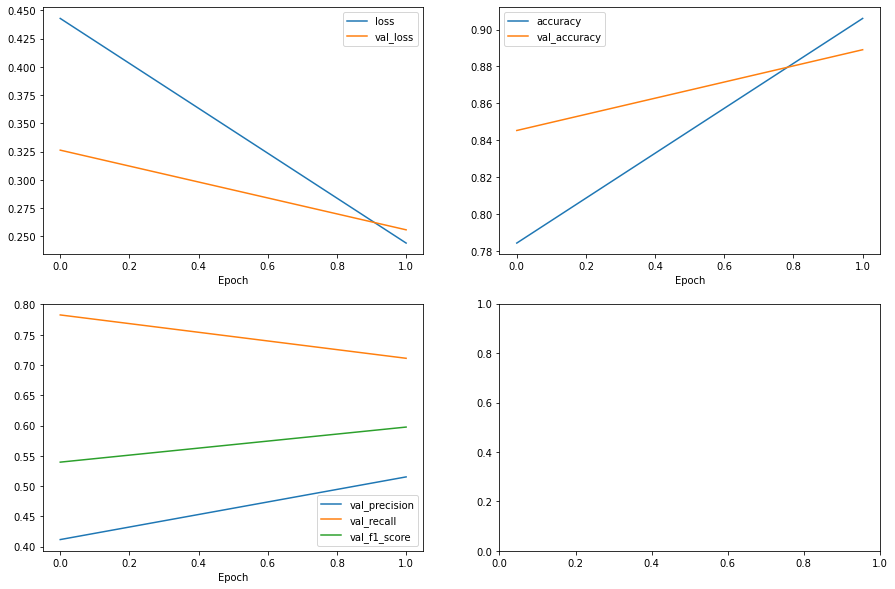

In [702]:
result_functions.plot_history_nn(history_nn_emb.history, 
                                combined_keys=[['loss', 'val_loss'], 
                                               ['accuracy', 'val_accuracy'],
                                               ['val_precision', 'val_recall', 'val_f1_score']],
                                calculate_f1_score=True)

Accuracy score: 0.889
Precision score: 0.515
Recall score: 0.711
F-score: 0.598

Max F1-Score: 0.631 (threshold: 0.626)



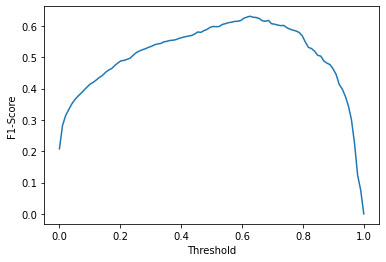

In [703]:

result_functions.print_scores(y_val, emb_model.predict(X_val_text_v), plot_fscore_threshold=True)

In [782]:
emb_model.save('models/emb_model')

INFO:tensorflow:Assets written to: models/emb_model/assets


### Сombining 2 models

Accuracy score: 0.837
Precision score: 0.307
Recall score: 0.323
F-score: 0.315

Max F1-Score: 0.339 (threshold: 0.414)



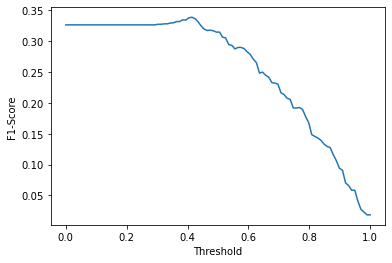

In [675]:
y_pred1 = lr_model.predict(X_val)
y_pred2 = emb_model.predict(X_val_text_v)
y_pred2 = np.where(np.array(y_pred2) > 0.606, 1, 0)

y_pred = [y_pred1[i] * y_pred2[i] for i in range(len(y_pred1))]

result_functions.print_scores(y_val, y_pred, plot_fscore_threshold=True)

#### *The results for Embedding layer better than for 2 models together*

# Ensemble nethods

In [632]:
# Create a embedding layer to vectoirzinf the text
emb_model_to_vect = keras.models.Sequential()
emb_model_to_vect.add(keras.layers.Embedding(input_dim=vocab_size, 
                                     output_dim=85,
                                     input_length=maxlen))
emb_model_to_vect.add(keras.layers.Flatten())
emb_model_to_vect.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['accuracy', 'Precision', 'Recall'])
emb_model_to_vect.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_82 (Embedding)     (None, 50, 85)            1343425   
_________________________________________________________________
flatten_74 (Flatten)         (None, 4250)              0         
Total params: 1,343,425
Trainable params: 1,343,425
Non-trainable params: 0
_________________________________________________________________


In [657]:
# Take the embedding layer from the previous NN
emb_layer = emb_model_to_vect.get_layer('embedding_82')
emb_layer.set_weights(emb_model.get_layer('embedding_81').get_weights())
emb_model_to_vect.predict(X_val_text).shape

### StackingClassifier

In [666]:
# Create StackingClassifier
estimators = [
            ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
            ('svr', make_pipeline(StandardScaler(),
                                    LinearSVC(random_state=42)))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [667]:
clf.fit(emb_model_to_vect.predict(X_train_text_v), y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())

Accuracy score: 0.895
Precision score: 0.791
Recall score: 0.131
F-score: 0.225

Max F1-Score: 0.225 (threshold: 0.0)



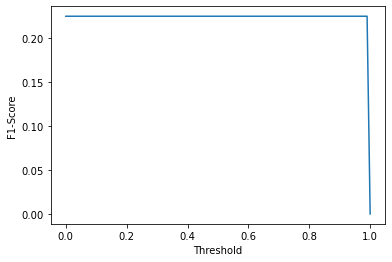

In [670]:
result_functions.print_scores(y_val, clf.predict(emb_model_to_vect.predict(X_val_text_v)), plot_fscore_threshold=True)

### XGBoost

In [770]:
%%time
# Create XGBoost
xgb_cl = XGBClassifier(max_depth=4, eta=1)
xgb_cl.fit(X_train_count_vect, y_train)

[00:53:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 9.61 s, sys: 3.22 s, total: 12.8 s
Wall time: 1.84 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy score: 0.87
Precision score: 0.456
Recall score: 0.635
F-score: 0.53

Max F1-Score: 0.53 (threshold: 0.0)



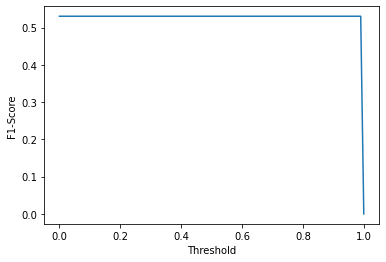

In [771]:
result_functions.print_scores(y_val, 
                              xgb_cl.predict(X_val_count_vect), 
                              plot_fscore_threshold=True)

#### *The best result remains for a neural network with an embedding layer*